
The following tutorial is an extension from the analysis code used in [ref](https://mne.tools/0.18/auto_tutorials/sample-datasets/plot_sleep.html)

# Research Question


Given two subjects from the Sleep Physionet dataset, namely Alice and Bob, how well can we predict the sleep stages of Bob from Alice's data?

This problem is tackled as supervised multiclass classification task. The aim
is to predict the sleep stage from 5 possible stages for each chunk of 30
seconds of data.

# Initial Setup

In [ ]:
 !pip freeze # Preinstall package

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.11
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.27
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==

In [ ]:
pip install mne mne_features

     |████████████████████████████████| 7.4 MB 5.4 MB/s 
     |████████████████████████████████| 40 kB 4.3 MB/s 
  Created wheel for mne-features: filename=mne_features-0.2-py3-none-any.whl size=26760 sha256=4e98a0a2bb209c2e466f0de957449a3e013f9be6ca98e186e5f06140e7a8b043
  Stored in directory: /root/.cache/pip/wheels/50/7d/94/905a24736d6d8ecd07fb249d02af5391afed5054d26a0b66b8
Successfully built mne-features


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.decoding import (Vectorizer)

from mne_features.feature_extraction import FeatureExtractor  # Take some time because of Numba
from mne_features.feature_extraction import extract_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline

In [ ]:
# from mne_features.utils import (_idxiter, power_spectrum, _embed, _get_feature_funcs,
#                     _get_feature_func_names, _psd_params_checker)


In [ ]:
# print(_get_feature_func_names(__name__))

# Load the data
------------



1.   Download sleep data from Sleep Physionet Dataset
2.   Read the downloaded file as raw
3.   Extract the annotation from the raw file
4.   Create epochs of 30 sec from the continous signal

In [ ]:
event_id = {'Sleep stage W': 1,
  'Sleep stage 1': 2,
  'Sleep stage 2': 3,
  'Sleep stage 3': 4,
  'Sleep stage 4': 4,
  'Sleep stage R': 5}

def some_operation(dpath):
  
  # Read the PSG data
  raw = mne.io.read_raw_edf(dpath[0], stim_channel='marker',misc=['rectal'])

  # Select only EEG
  raw.drop_channels(['EOG horizontal','Resp oro-nasal','EMG submental','Temp rectal',
                       'Event marker'])
  
  scalings = dict(eeg=40e-5)
  raw.plot(duration=60, scalings=scalings,remove_dc=False,)
  tmax = 30. - 1. / raw.info['sfreq']  # Epoch size
  # print(tmax)

  # Extract the annotation from the raw file
  annot = mne.read_annotations(dpath[1])
  annot.crop(annot[1]['onset'] - 30 * 60,annot[-2]['onset'] + 30 * 60)
  
  raw.set_annotations(annot, emit_warning=False)
  events, _ = mne.events_from_annotations(raw, event_id=event_id, chunk_duration=30.)
  # u, indices = np.unique(annot['description'], return_index=True)

  # Create epochs of 30 sec from the continous signal
  epochs = mne.Epochs(raw=raw, events=events, event_id=event_id,tmin=0., tmax=tmax, baseline=None)
  
  return epochs

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Using matplotlib as 2D backend.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


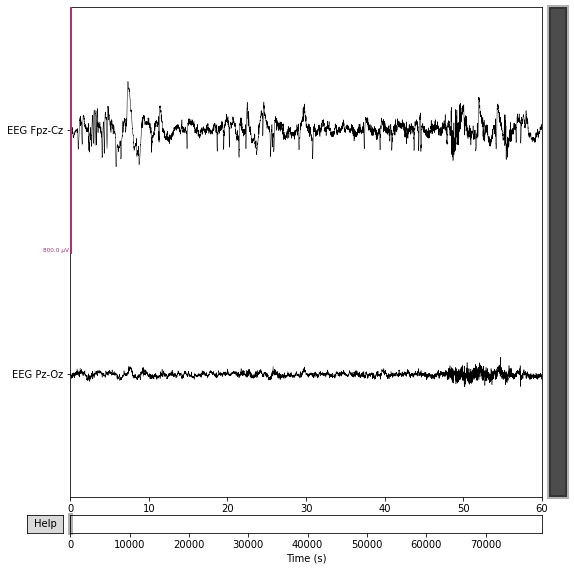

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


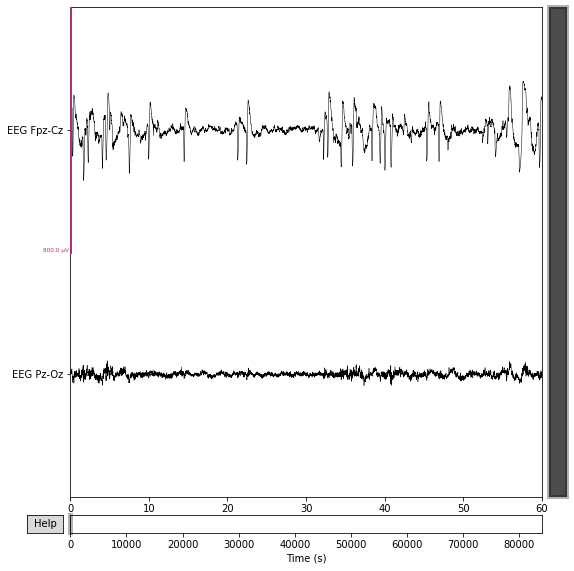

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
ALICE, BOB = 0, 1

# Download data from sleep Physionet dataset
all_data = fetch_data(subjects=[ALICE, BOB], recording=[1])

# Read the PSG data and Hypnograms to create a raw object
all_ep=[some_operation(dpath) for dpath in all_data]


epochs_alice,epochs_bob=all_ep

In [ ]:
# print(epochs_alice)
epochs_alice.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 2
 projs: []
 sfreq: 100.0 Hz
>

# Power Spectral Density
# -------------------

Visualize Alice vs. Bob PSD by sleep stage.


Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS w

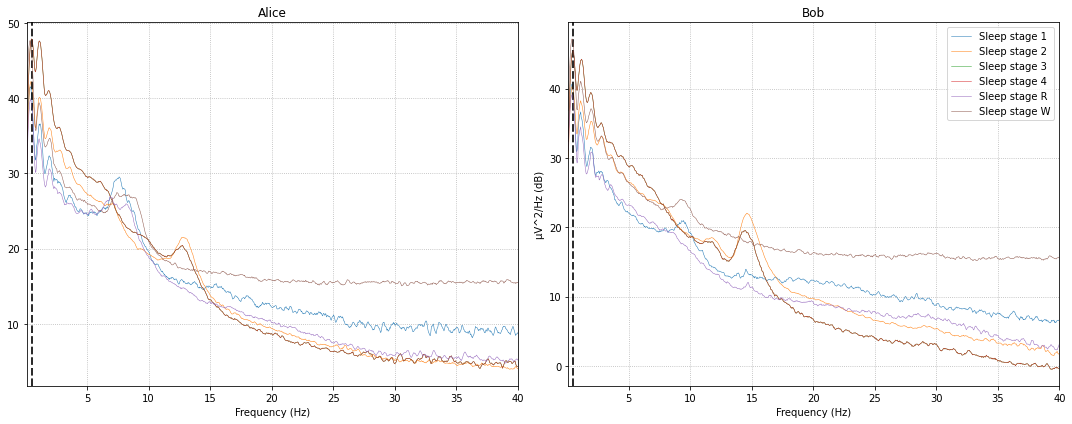

In [ ]:
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,6))

# # iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2],
 ['Alice', 'Bob'],
 [epochs_alice,epochs_bob]):
  
  for stage, color in zip(stages, stage_colors):
    epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,fmin=0.1, fmax=40., show=False,
      average=True, spatial_colors=False)
    
  ax.set(title=title, xlabel='Frequency (Hz)')
ax2.set(ylabel='µV^2/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.tight_layout()
plt.show()

# Feature Engineering
# -------------------

The rest of this section we will create EEG features based on relative power
in specific frequency bands to capture this difference between the sleep
stages in our data.

## Custom Function (A)

In [ ]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

## Feature Extracted From mne-feature

In [ ]:
def eeg_power_band(epochs):
  """EEG relative power band feature extraction.

  This function takes an ``mne.Epochs`` object and creates EEG features based
  on relative power in specific frequency bands that are compatible with
  scikit-learn.

  Parameters
  ----------
  epochs : Epochs
      The data.

  Returns
  -------
  X : numpy array of shape [n_samples, 5]
      Transformed data.
  """
  # specific frequency bands
  FREQ_BANDS = {"delta": [0.5, 4.5],
    "theta": [4.5, 8.5],
    "alpha": [8.5, 11.5],
    "sigma": [11.5, 15.5],
    "beta": [15.5, 30]}


  # 
  selected_features = ['pow_freq_bands']

  freq_bands=np.unique(np.concatenate(list(map(list, (FREQ_BANDS.values())))))

  funcs_params = dict ( pow_freq_bands__normalize=False,pow_freq_bands__ratios='all',pow_freq_bands__psd_method='fft',pow_freq_bands__freq_bands=freq_bands)
  
  sfreq=epochs.info ['sfreq']
  features_all = extract_features ( epochs.get_data (), sfreq,selected_funcs=selected_features, return_as_df=True,funcs_params=funcs_params)


  return features_all.to_numpy()

List of feature



1.   Bivariate


* max_cross_correlation, 
* Maximum linear cross-correlation, 
* Phase Locking Value, 
* Measure of nonlinear interdependence, 
* Correlation Coefficients, 
* Correlation Coefficients

2.   Univariate

* Slope of a 1D least-squares regression, 
* Mean of the data (per channel), 
* Variance of the data (per channel), 
* Standard deviation of the data, 
* Peak-to-peak (PTP) amplitude of the data (per channel), 
* Skewness of the data (per channel), 
* Kurtosis of the data (per channel), 
* Root-mean squared value of the data (per channel), 
* Quantile of the data (per channel), 
* Hurst exponent of the data (per channel),
* Approximate Entropy (AppEn, per channel),
* Sample Entropy (SampEn, per channel), 
* Decorrelation time (per channel),
* Power Spectrum (computed by frequency bands), 
* Hjorth mobility (per channel),
* Hjorth complexity (per channel), 
* Hjorth mobility (per channel), 
* Hjorth complexity (per channel), 
* Higuchi Fractal Dimension (per channel), 
* Katz Fractal Dimension (per channel), 
* Number of zero-crossings (per channel), 
* Line length (per channel), 
* Spectral Entropy (per channel), 
* SVD entropy (per channel), 
* Linear regression of the the log-log frequency-curve (per channel), 
SVD Fisher Information (per channel), 
* Band energy (per channel), 
* Spectal Edge Frequency (per channel), 
* Energy of Wavelet decomposition coefficients (per channel)

# Multiclass classification workflow using scikit-learn and mne-feature
# -----------------------------------------------------

- `Pipeline`

is just an abstract notion, it's not some existing ml algorithm. Often in ML tasks you need to perform sequence of different transformations (find set of features, generate new features, select only some good features) of raw dataset before applying final estimator.

- `FunctionTransformer`

some class that have fit and transform method, or fit_transform method.
- `eeg_power_band`



## Custom function approach

In [ ]:
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Pipeline
# FunctionTransformer

"""
1) Extract Feature from the eeg_power_band
2) fit and predict method using random forest
"""

pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),RandomForestClassifier(n_estimators=100, random_state=42))


epochs_train,epochs_test=epochs_alice,epochs_bob
y_train = epochs_alice.events[:, 2]
pipe.fit(epochs_alice, y_train)

# Test
y_pred = pipe.predict(epochs_bob)
# epochs.get_data ()
# Assess the results


y_test = epochs_bob.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
# Further analysis of the data
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# We can check the confusion matrix or the classification report.

print(confusion_matrix(y_test, y_pred))

##############################################################################

print(classification_report(y_test, y_pred,target_names={'Sleep stage W': 1,
  'Sleep stage 1': 2,
  'Sleep stage 2': 3,
  'Sleep stage 3/4': 4,
  'Sleep stage R': 5}))

Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 1103 events and 3000 original time points ...
0 bad epochs dropped
Accuracy score: 0.6745240253853128
[[151   0   1   5   0]
 [ 88  12   6   1   2]
 [ 33  30 468  28   3]
 [  0   0   2 103   0]
 [ 49 100  11   0  10]]
                 precision    recall  f1-score   support

  Sleep stage W       0.47      0.96      0.63       157
  Sleep stage 1       0.08      0.11      0.10       109
  Sleep stage 2       0.96      0.83      0.89       562
Sleep stage 3/4       0.75      0.98      0.85       105
  Sleep stage R       0.67      0.06      0.11       170

       accuracy                           0.67      1103
      macro avg       0.59      0.59      0.52      1103
   weighted avg       0.74      0.67      0.65      1103



## FeatureExtractor Approach

In [ ]:
FREQ_BANDS = {"delta": [0.5, 4.5],"theta": [4.5, 8.5],"alpha": [8.5, 11.5], "sigma": [11.5, 15.5],"beta": [15.5, 30]}


selected_features = ['pow_freq_bands']

freq_bands=np.unique(np.concatenate(list(map(list, (FREQ_BANDS.values())))))

# raw_testx = mne.io.read_raw_edf(all_data[0][0], stim_channel='marker',misc=['rectal'])
# sfreq=raw_testx.info['sfreq']

sfreq=100

In [ ]:
# from mne_features.feature_extraction import FeatureExtractor  # Take some time because of Numba

# selected_funcs = ['line_length', 'kurtosis', 'ptp_amp', 'skewness','pow_freq_bands']
from sklearn.pipeline import Pipeline
selected_funcs = ['pow_freq_bands']
funcs_params = dict ( pow_freq_bands__normalize=False,
                     pow_freq_bands__ratios='all',
                     pow_freq_bands__psd_method='fft',
                     pow_freq_bands__freq_bands=freq_bands)



# FeatureExtractor >> function under mne-feature
pipe = make_pipeline( FeatureExtractor(sfreq=sfreq,params=funcs_params,
                                       selected_funcs=selected_funcs),
                    Vectorizer(),
                    RandomForestClassifier(n_estimators=100, random_state=42))



# epochs_train,epochs_test=epochs_alice,epochs_bob
pipe.fit(epochs_alice.get_data (), epochs_alice.events[:, 2])

# Test
y_pred = pipe.predict(epochs_bob.get_data ())

# Assess the results
y_test = epochs_bob.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))
# Further analysis of the data
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# We can check the confusion matrix or the classification report.

print(confusion_matrix(y_test, y_pred))


print(classification_report(y_test, y_pred,target_names={'Sleep stage W': 1,
                                                          'Sleep stage 1': 2,
                                                          'Sleep stage 2': 3,
                                                          'Sleep stage 3/4': 4,
                                                          'Sleep stage R': 5}))

Loading data for 841 events and 3000 original time points ...
Loading data for 1103 events and 3000 original time points ...
Accuracy score: 0.6745240253853128
[[151   0   1   5   0]
 [ 88  12   6   1   2]
 [ 33  30 468  28   3]
 [  0   0   2 103   0]
 [ 49 100  11   0  10]]
                 precision    recall  f1-score   support

  Sleep stage W       0.47      0.96      0.63       157
  Sleep stage 1       0.08      0.11      0.10       109
  Sleep stage 2       0.96      0.83      0.89       562
Sleep stage 3/4       0.75      0.98      0.85       105
  Sleep stage R       0.67      0.06      0.11       170

       accuracy                           0.67      1103
      macro avg       0.59      0.59      0.52      1103
   weighted avg       0.74      0.67      0.65      1103



In [ ]:
# pipe = Pipeline([('fe', FeatureExtractor(sfreq=sfreq,params=funcs_params,
#                                        selected_funcs=selected_funcs)),('vectorise',Vectorizer()),('clf',  RandomForestClassifier(n_estimators=100, random_state=42))])
